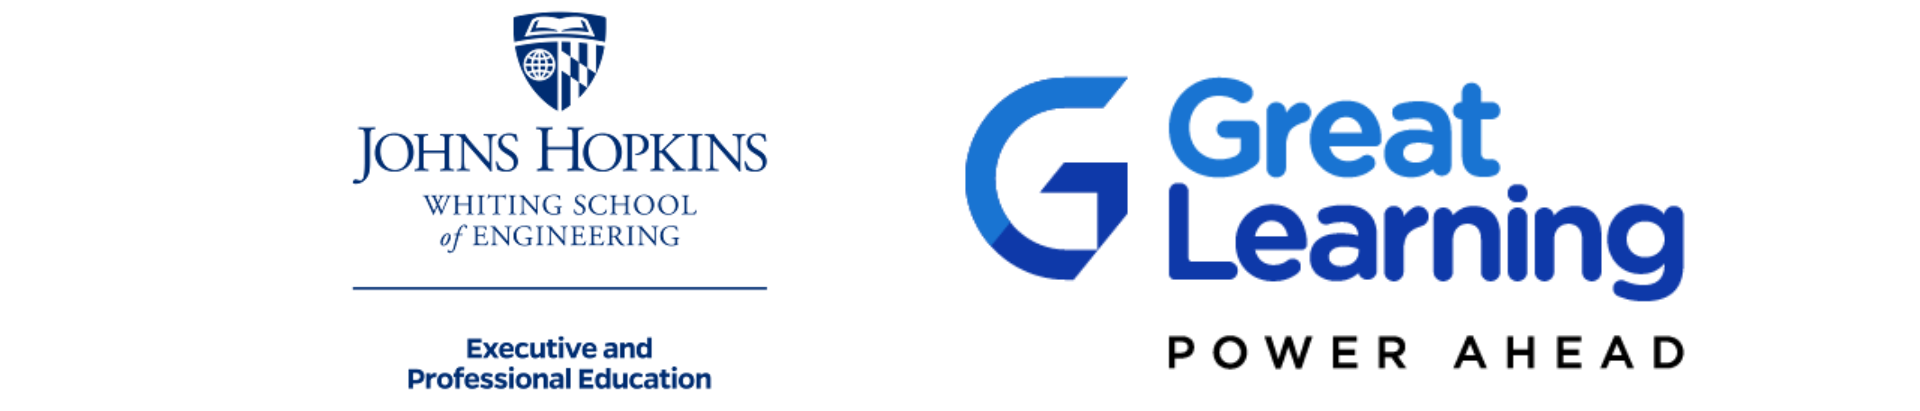

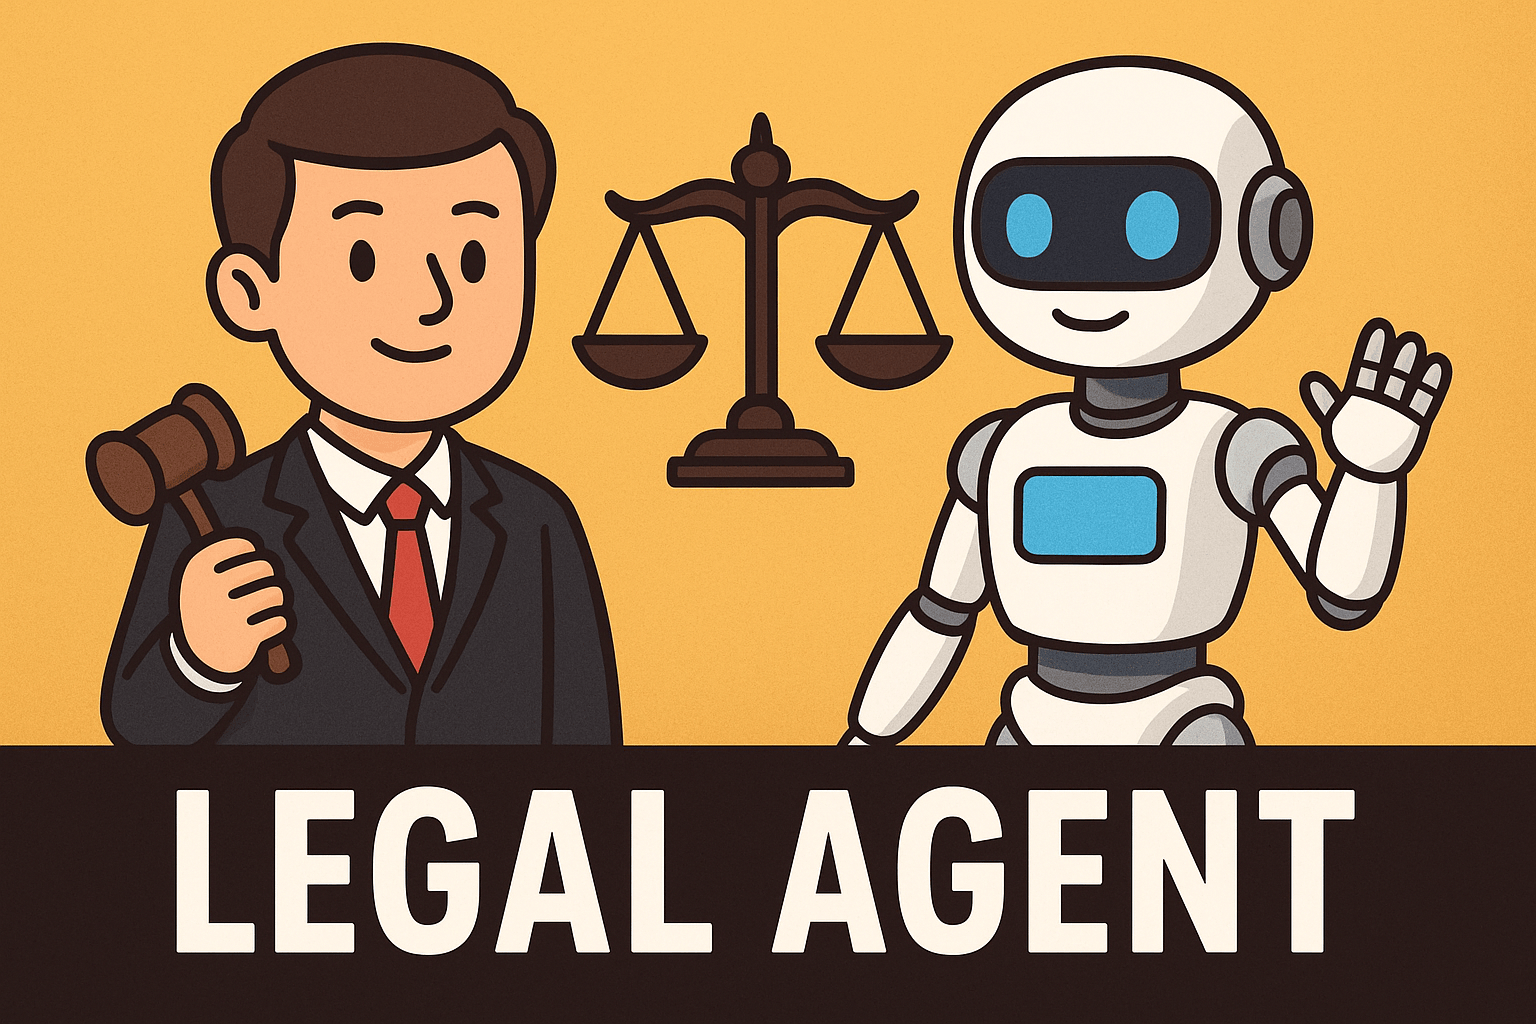

##Business Context

Legal professionals today deal with growing complexity, large volumes of case documents, and constant updates in legal precedents. Manual research is slow, costly, and often inconsistent, leading to missed insights and weaker legal strategies. Traditional databases make it difficult to quickly find relevant precedents or identify loopholes in arguments. As legal workloads increase, firms need faster, smarter tools that can support comprehensive case analysis and reduce dependency on manual effort.

###Key Points

- Manual legal research consumes significant lawyer time and increases operational costs.

- Thousands of precedents and legal updates make complete analysis difficult.

- Inconsistent research quality leads to overlooked loopholes and missed arguments.

- Smaller firms struggle more due to limited resources and research capacity.

- AI-driven analysis can provide faster insights, improved accuracy, and competitive advantage.

##Objective

The objective is to build an AI-powered legal analysis agent that provides accurate, comprehensive, and current insights by using three key tools:

1. **RAG with Past Case Information** to retrieve and analyze relevant historical legal cases.  
2. **Tavily Web Search** to include real-time legal developments and external precedents.  
3. **Loophole Analysis** to identify weaknesses, gaps, and vulnerabilities in legal arguments.

The output from this workflow is evaluated using the DeepEval framework under the metrics of **Tool Correctness**, **Task Completion**, and **Answer Relevancy**. This ensures a clear measurement of how effectively and reliably the agent performs.


##Architectural Workflow
The workflow starts with the **Input Legal Case**, which is processed through three tools: **RAG with past case information**, **Tavily Web Search**, and **Loophole Analysis**. These outputs are merged to create a **Combined Analysis Output**. The combined result is evaluated using **DeepEval** across three metrics: **Tool Correctness**, **Task Completion**, and **Answer Relevancy**. The evaluation results come together to determine the **Final Agent Performance**, indicating how effectively the AI agent analyzed the case.


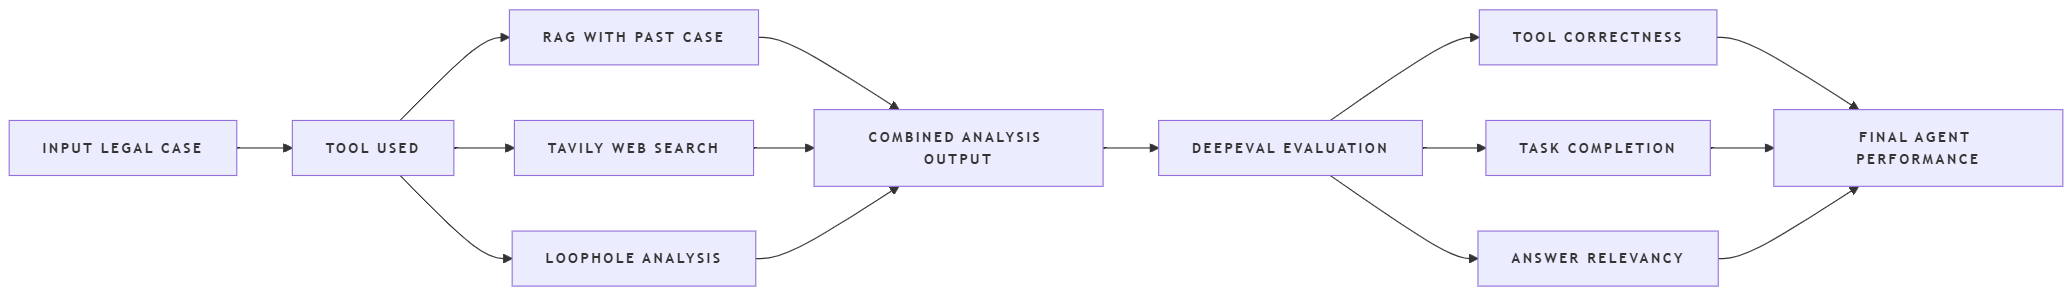

# Installing the Libraries

**Note:** You may see an error that begins with: *“pip's dependency resolver does not currently take into account all the packages that are installed.”* This is expected and will not affect the process. You can safely continue running the cells below.


In [33]:
# Installing the Libraries
!pip install -q openai==1.66.3 \
                langchain==0.3.20 \
                langchain-openai==0.3.9 \
                langchain_experimental==0.3.4 \
                langchain-tavily==0.2.4 \
                langchain-chroma \
                langgraph==0.3.21 \
                mermaid-python==0.1 \
                langgraph-supervisor==0.0.18 \
                deepeval==2.8.2 \
                pypdf==5.4.0 \
                chromadb

## Importing the Libraries:

Key Libraries:

- `openai` - Interface with OpenAI's API
- `langchain` - Framework for building LLM applications
- `langchain-openai` - LangChain integrations for OpenAI models
- `langgraph` - Graph-based workflow orchestration
- `langchain-tavily` - Web search integration
- `chromadb` - Vector database for RAG
- `deepeval` - Library for performing evaluation


In [ ]:
# Standard Library for file and environment operations
import os, json, re, ast, uuid, random
from typing import Any, Annotated, Dict, List, Literal, Optional, Tuple, TypedDict

# Pydantic models for Data Validation
from pydantic import BaseModel, Field

# Mermaid Library for visualizing LangGraph workflows
from mermaid import Mermaid

from openai import OpenAI

# LangChain imports
from langchain_core.documents import Document
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage, ToolMessage
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.tools import tool, StructuredTool
from langchain.document_loaders import PyPDFLoader
from langchain.vectorstores import Chroma
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.vectorstores import InMemoryVectorStore

# LangGraph imports to define agentic workflows
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver

# Deepeval imports
from deepeval import evaluate
from deepeval.metrics import TaskCompletionMetric, ToolCorrectnessMetric
from deepeval.test_case import LLMTestCase, ToolCall

# Colab secrets to load OpenAI API Key
from google.colab import userdata

Configuring the Credentials

###Steps to get Tavily API:

- Visit https://www.tavily.com/ and click `Login`
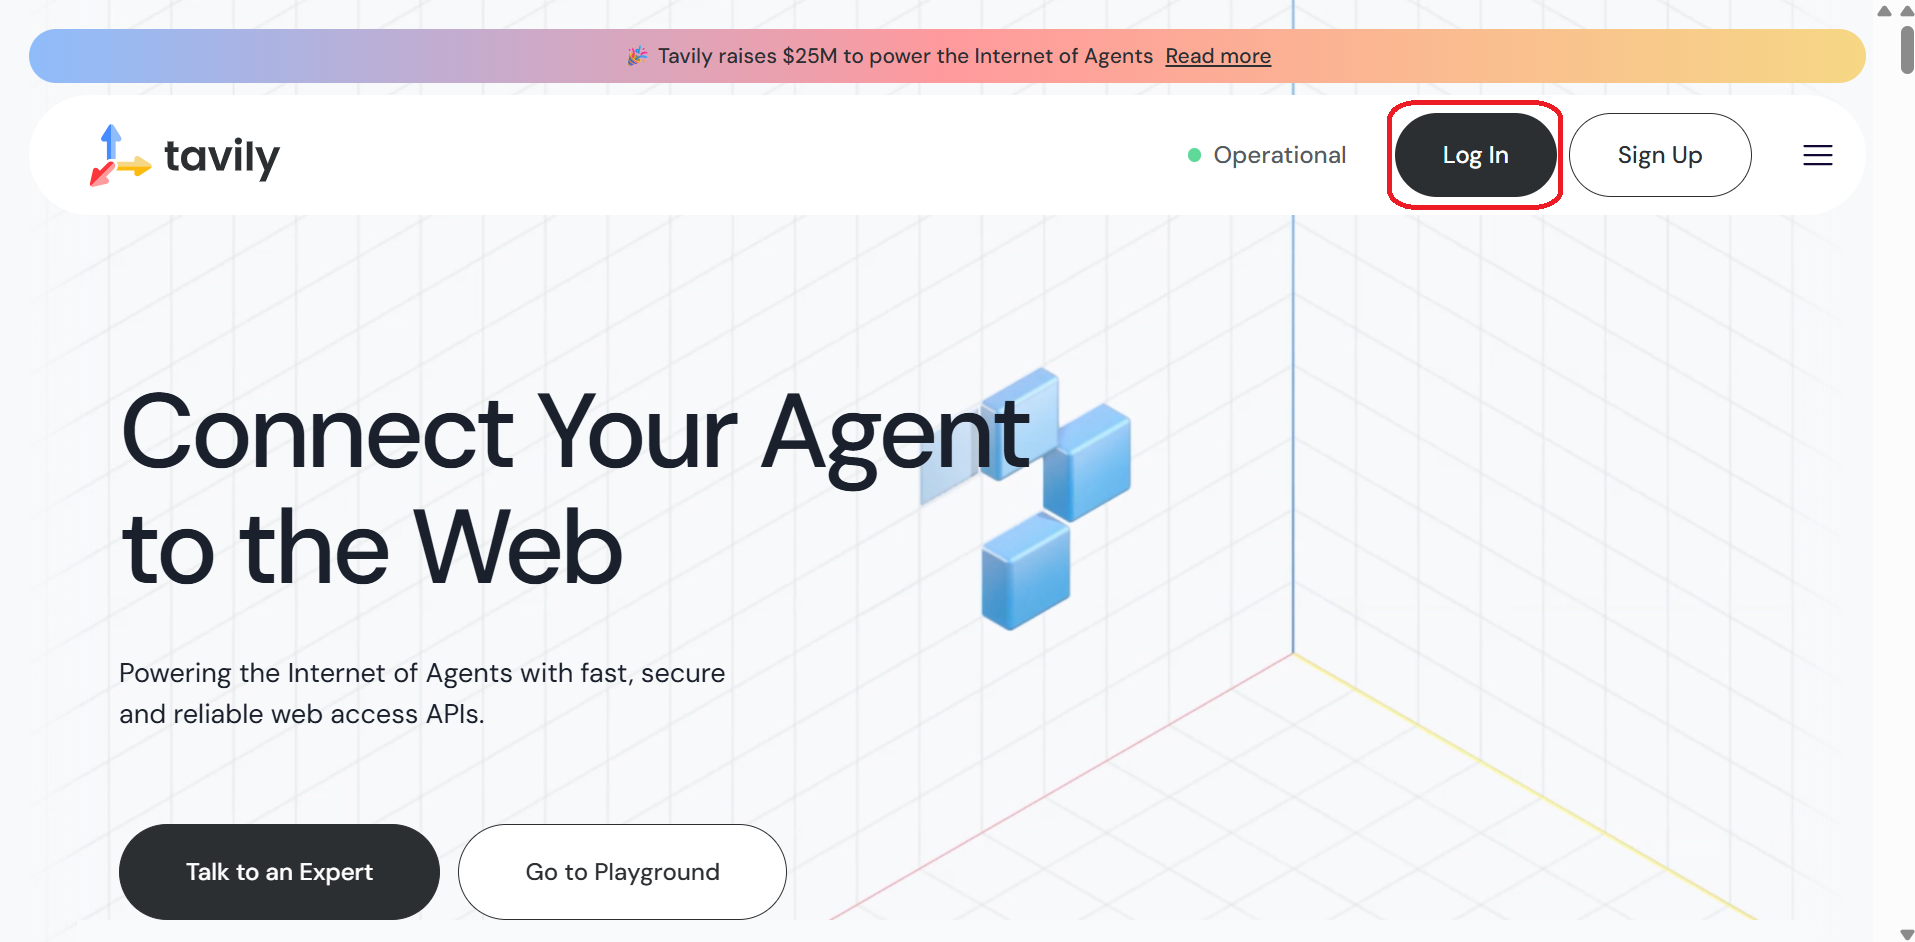


- Click on `Continue with Google`
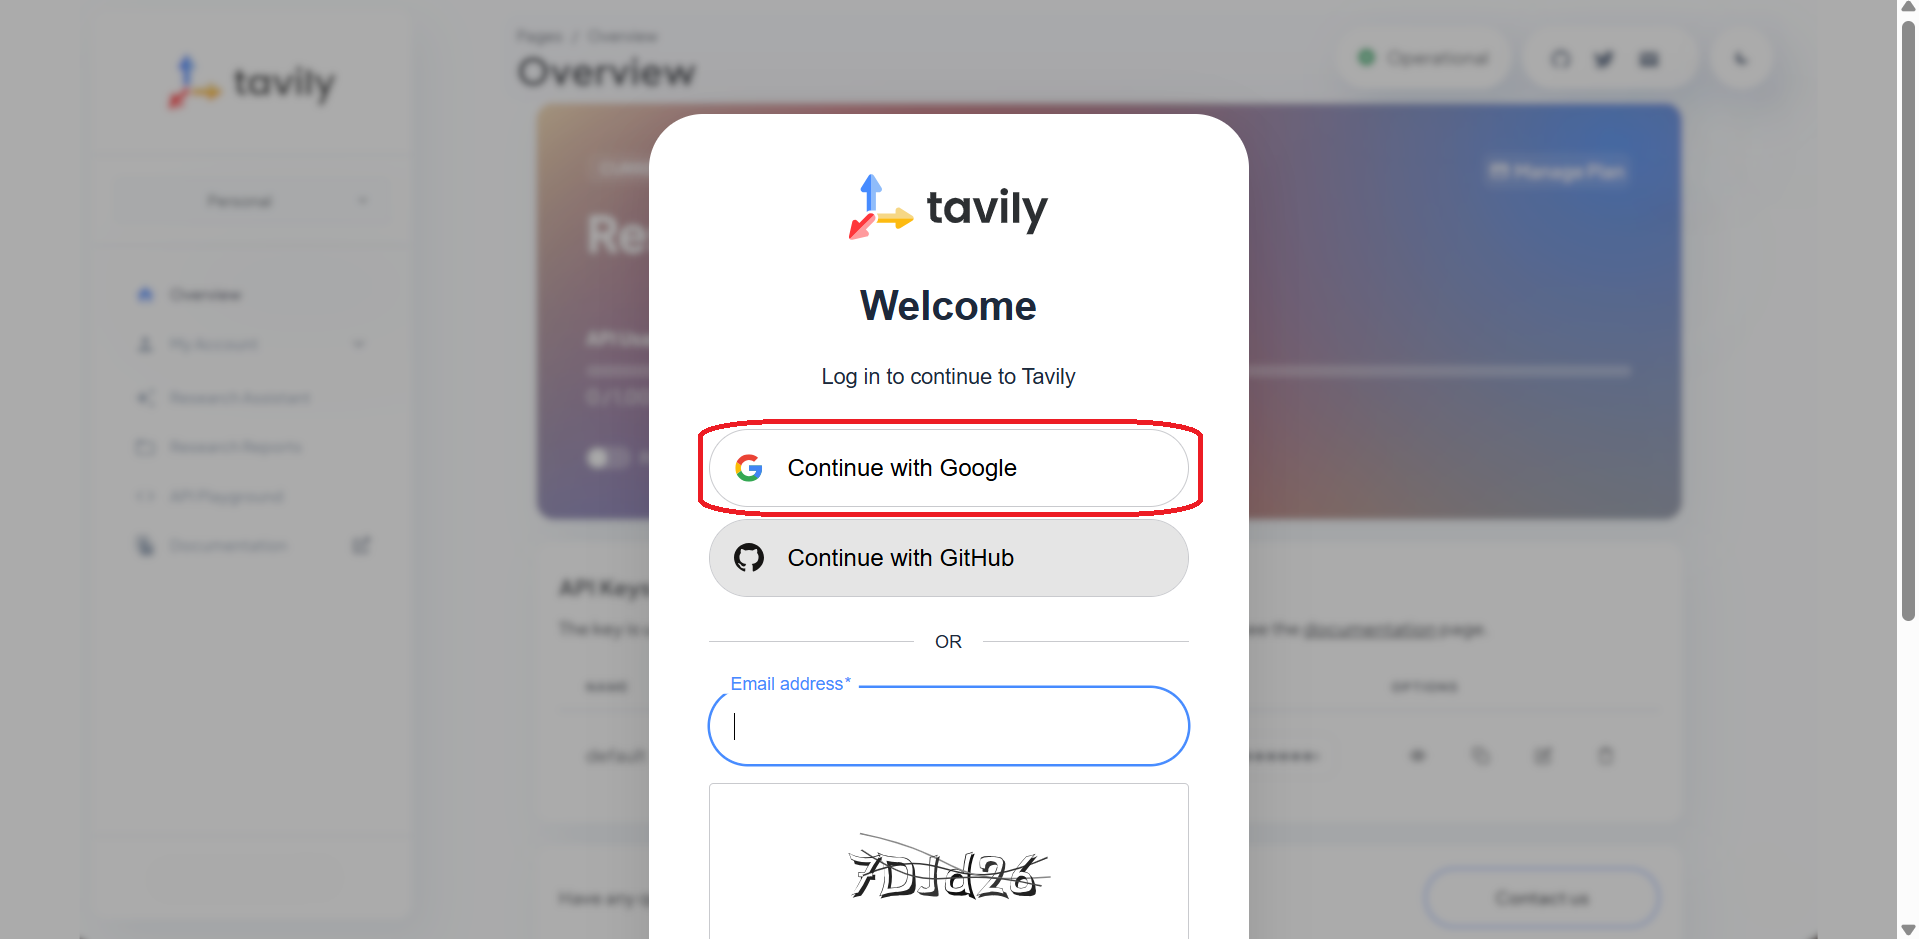

- Scroll down to see `API Key`
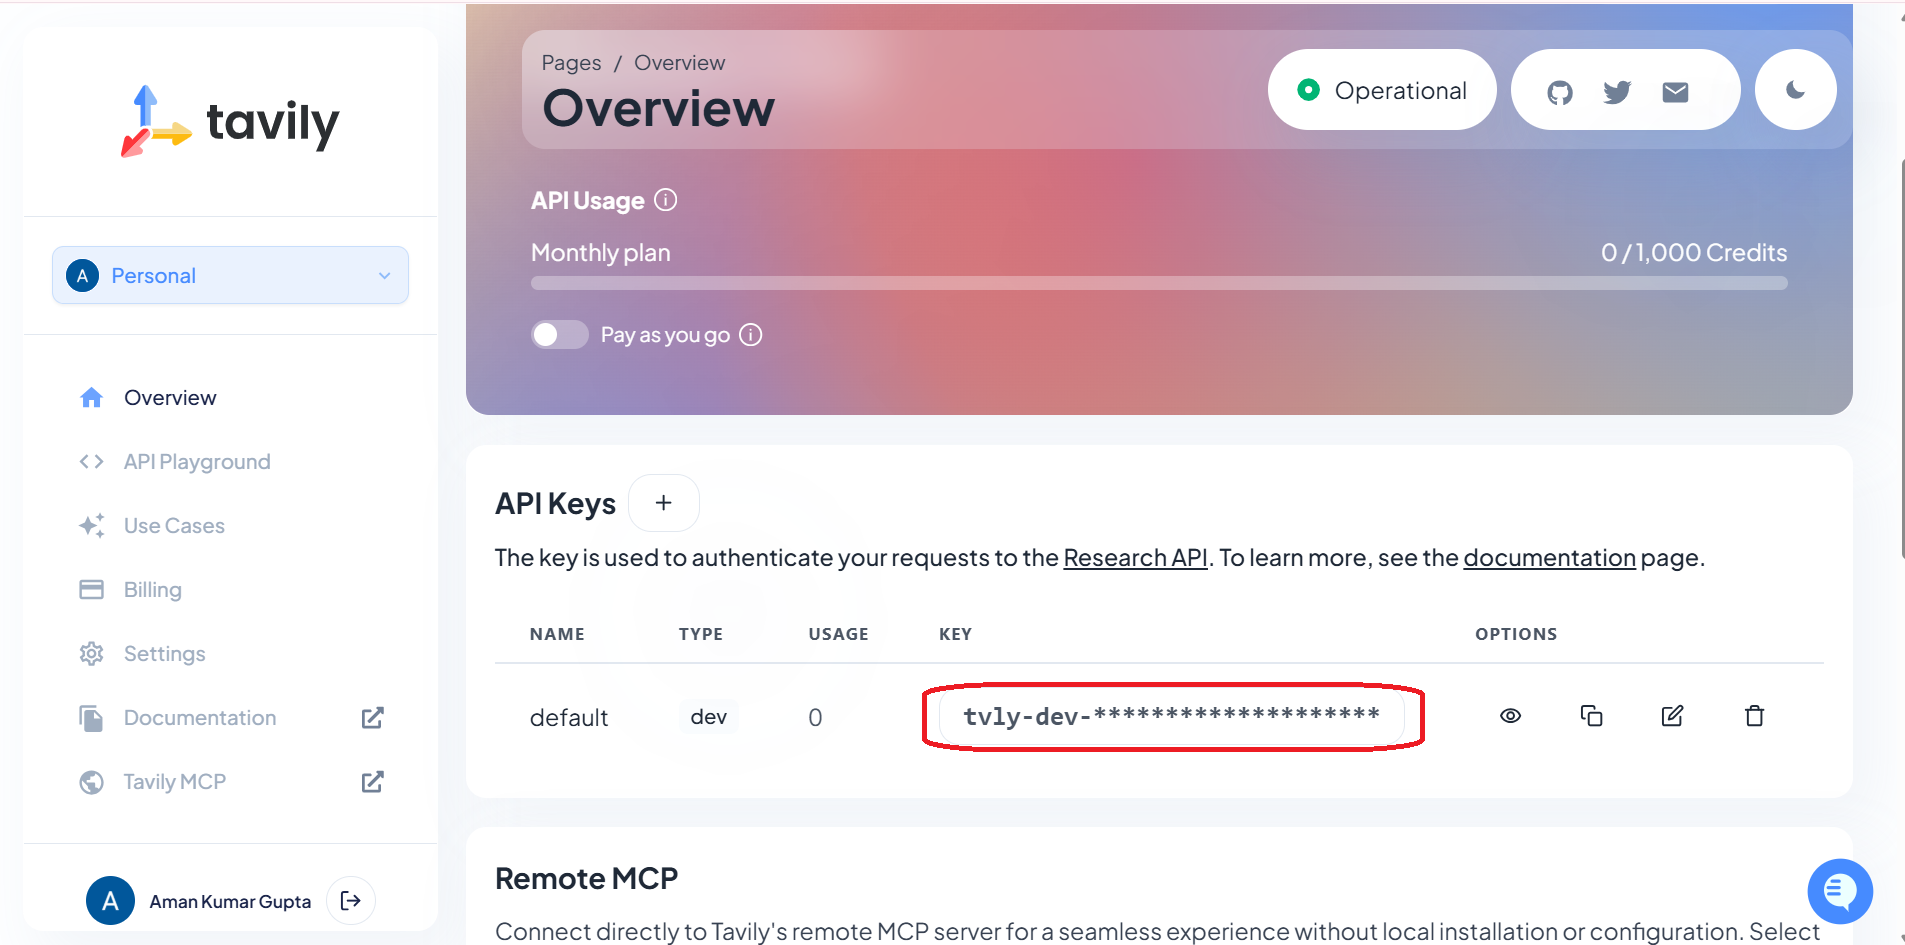


- Set secret on Colab for `tavily_search_api_key` or add it in the `config.json` file
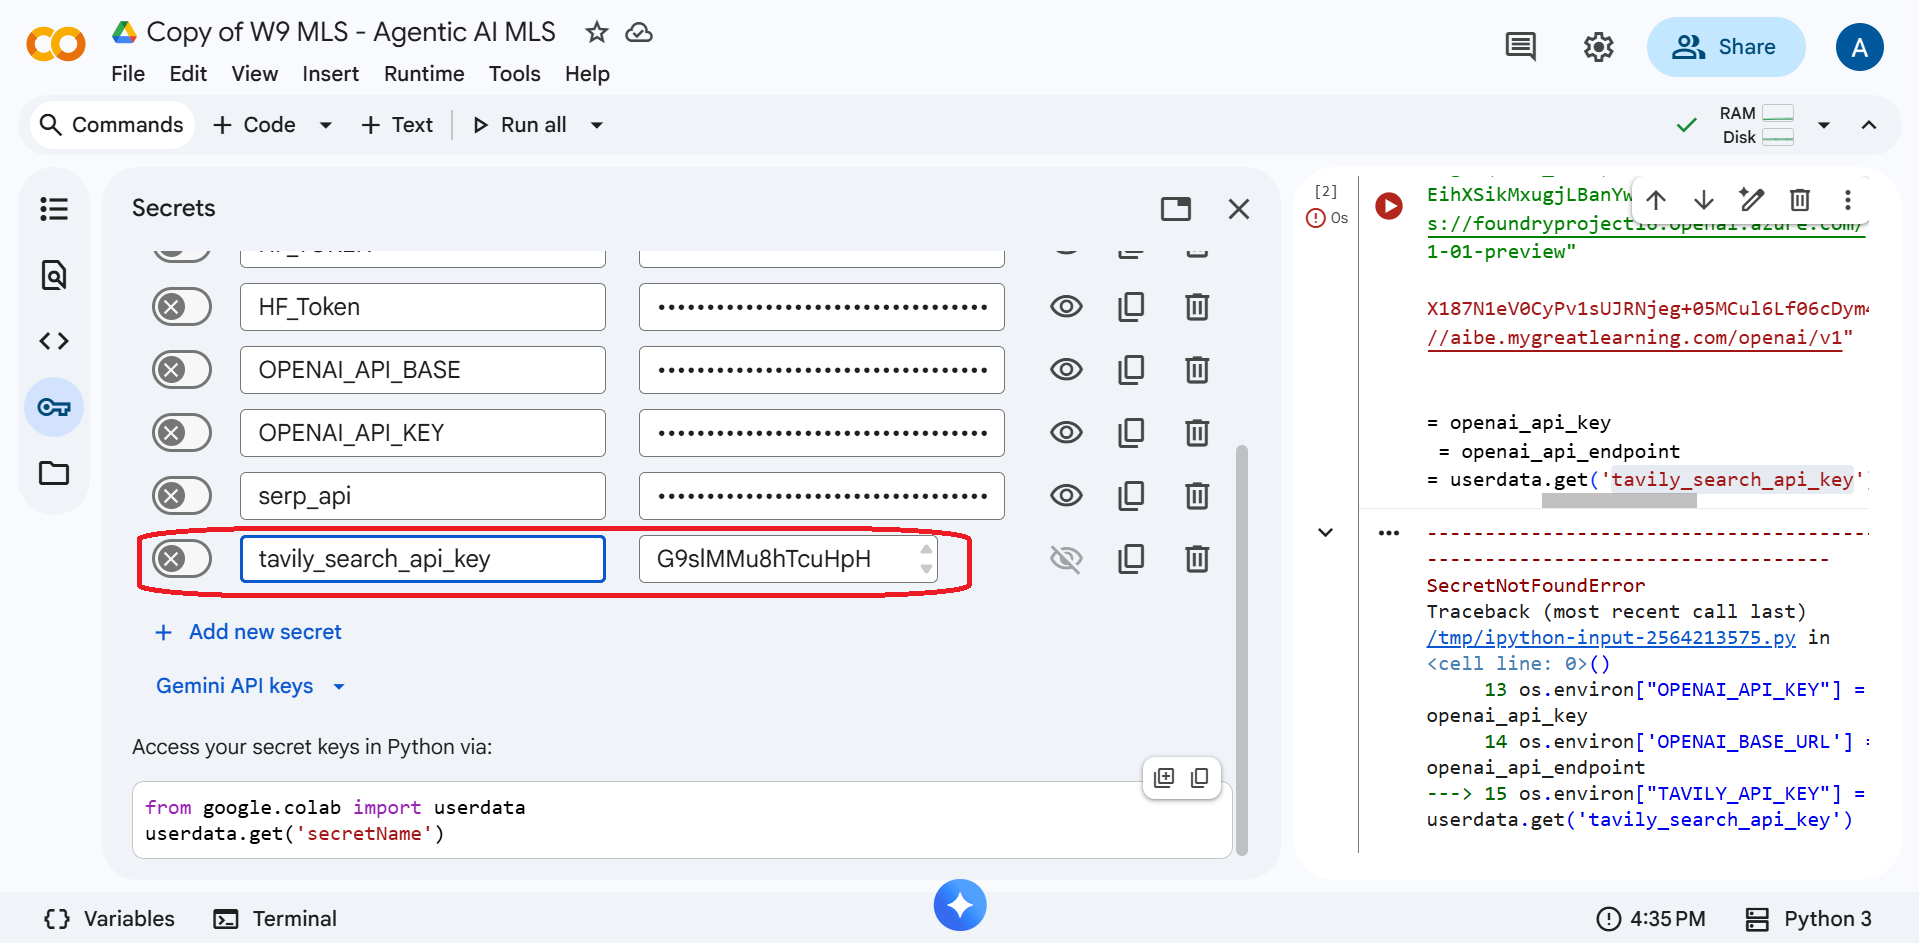


In [ ]:
#Loading the `config.json` file
import json
import os

# Load the JSON file and extract values
file_name = 'config.json'
with open(file_name, 'r') as file:
    config = json.load(file)
    os.environ['OPENAI_API_KEY'] = config.get("API_KEY")              # Loading the API Key
    os.environ["OPENAI_BASE_URL"] = config.get("OPENAI_API_BASE")     # Loading the API Base Url
    os.environ["TAVILY_API_KEY"] = config.get("TAVILY_API_KEY")       # Tavily search setup

Configuring the LLM and Embedding models

In [36]:
# LLM model
model_name = 'gpt-4o-mini'  # lightweight & fast version of gpt-4o optimized for performance

llm = ChatOpenAI(
    model = model_name,
    temperature = 0,
)

embedding_model = OpenAIEmbeddings(
    model = "text-embedding-3-small"
)

The following steps will be followed for creating the LangGraph workflows:
1. Define the Agent State
2. Define the Tools and Workflow node(s)
3. Graph Construction
4. Workflow Execution



# Define the Agent State

In [38]:
class AgentState(TypedDict):
    """
    Defines the state structure for the legal analysis agent.
    """
    messages: Annotated[list, add_messages]
    case_text: str
    final_analysis: str

## Tool Definitions

For the legal case analysis, we define three tools:
- LLM Reasoning Tool to analyse a given case for loopholes
- RAG Tool that searches legal case documents using RAG
- Tavily Search Tool that searches for precendents only

### RAG Tool

In [39]:
vectorstore = None

@tool
def rag_search_tool(query: str) -> str:
    """
    Search legal case documents using RAG for similar precedents and relevant information.

    Args:
        query: The search query for finding relevant legal information

    Returns:
        Relevant legal information from the knowledge base
    """
    global vectorstore

    if vectorstore is None:
        return "RAG system not initialized. Please load case documents first."

    # Perform similarity search
    docs = vectorstore.similarity_search(query, k=3)

    if not docs:
        return "No relevant legal precedents found in the knowledge base."

    # Format results
    results = []
    for i, doc in enumerate(docs, 1):
        results.append(f"Precedent {i}:\n{doc.page_content}")

    return "\n\n".join(results)


### Tavily Web Search Tool

In [40]:
@tool
def tavily_web_search_tool(query: str) -> str:
    """
    Search the web using Tavily for recent legal cases and precedents.

    Args:
        query: The search query for web search

    Returns:
        Web search results with relevant legal information
    """
    tavily_tool = TavilySearchResults(max_results=3)
    results = tavily_tool.invoke({"query": query})

    if not results:
        return "No web search results found."

    # Format results
    formatted_results = []
    for i, result in enumerate(results, 1):
        content = result.get("content", "No content available")
        url = result.get("url", "No URL")
        formatted_results.append(f"Result {i}:\n{content}\nSource: {url}")

    return "\n\n".join(formatted_results)


### LLM Reasoning Tool to analyse Legal Loopholes

In [41]:
@tool
def analyze_loopholes_tool(case_summary: str) -> str:
    """
    Analyze legal case to identify potential loopholes using LLM reasoning.

    Args:
        case_summary: Summary of the case to analyze

    Returns:
        Analysis of potential legal loopholes
    """
    analysis_prompt = f"""
    You are a senior legal analyst. Analyze the following case and identify potential loopholes:

    Case Summary:
    {case_summary}

    Identify:
    1. Procedural loopholes
    2. Evidentiary gaps
    3. Jurisdictional issues
    4. Statute of limitations concerns
    5. Constitutional challenges

    Provide a detailed analysis with reasoning.
    """

    response = llm.invoke([HumanMessage(content=analysis_prompt)])
    return response.content

## Creating a Tools Registry

In [42]:
# Create tools list
tools = [rag_search_tool, tavily_web_search_tool, analyze_loopholes_tool]

In [43]:
# Create tools list
llm_with_tools = llm.bind_tools(tools)

## RAG Initialization

The `initialize_rag_system()` python function initializes the RAG system by reading the legal documents and performing the necessary pre-processing steps such as document chunking, generating the embeddings and saving the embeddings to the Chroma vector database.

In [44]:
def initialize_rag_system(legal_documents: List[str]):
    """
    Initialize the RAG system with legal documents.
    """
    global vectorstore

    # Create documents
    docs = [Document(page_content=doc) for doc in legal_documents]

    # Split documents
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=1000,
        chunk_overlap=200
    )
    splits = text_splitter.split_documents(docs)

    # Create vector store
    vectorstore = Chroma.from_documents(
        documents=splits,
        embedding=embedding_model,
        collection_name="legal_cases"
    )

    print(f"RAG system initialized with {len(splits)} document chunks")

# Defining Agent Nodes



In [45]:
def agent_node(state: AgentState) -> AgentState:
    """
    Main agent node that reasons and uses tools via ReAct pattern.
    """
    messages = state["messages"]

    # System prompt for the agent
    system_prompt = SystemMessage(content=f"""
    You are an expert legal analysis AI agent specializing in identifying loopholes and weaknesses in legal cases.

    **Case to Analyze:**
    {state["case_text"]}

    **Your Task:**
    Conduct a comprehensive legal analysis by:
    1. Searching for similar precedent cases using rag_search_tool
    2. Finding recent legal developments using tavily_web_search_tool
    3. Analyzing for loopholes using analyze_loopholes_tool

    **Analysis Framework:**
    - Force majeure defenses and procedural requirements
    - Notice requirements and timelines
    - Burden of proof and evidence standards
    - Contributory negligence considerations
    - Damages calculation and substantiation

    After gathering all information, provide a comprehensive final analysis synthesizing:
    - Relevant precedents found
    - Identified procedural loopholes
    - Evidentiary weaknesses
    - Strategic recommendations

    Be thorough and use all available tools before concluding.
    """)

    # Bind tools to LLM
    llm_with_tools = llm.bind_tools(tools)

    # Invoke agent
    response = llm_with_tools.invoke([system_prompt] + messages)

    return {"messages": [response]}

In [46]:
def should_continue(state: AgentState) -> Literal["tools", "end"]:
    """
    Determine whether to use tools or end the workflow.
    """
    last_message = state["messages"][-1]

    # If the LLM makes tool calls, route to tools node
    if hasattr(last_message, "tool_calls") and last_message.tool_calls:
        return "tools"

    # Otherwise, end the workflow
    return "end"

# Agent Workflow Definition
We compiled the graph using the `agent` node we designed and the `ToolNode`, which we created by adding all the tools.

In [47]:
workflow = StateGraph(AgentState)

# Add nodes
workflow.add_node("agent", agent_node)
workflow.add_node("tools", ToolNode(tools))

# Set entry point
workflow.set_entry_point("agent")

# Add conditional edges
workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "tools": "tools",
        "end": END
    }
)

# Tools always route back to agent
workflow.add_edge("tools", "agent")

# Compile the graph with memory
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)

## Visualizing the Agent Workflow

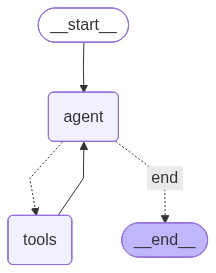

In [48]:
try:
    from IPython.display import Image, display
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

## Sample Legal Case

In [49]:
# Sample legal case text
SAMPLE_CASE = """
Case No: 2024/CR/12345
Court: District Court, US

Facts:
The defendant, Mr. Alex Carter, was charged with breach of contract dated January 15, 2023.
The plaintiff, ABC Corporation, claims that the defendant failed to deliver 1000 units of
electronic components as per the signed agreement. The contract specified delivery by March 31, 2023.

The defendant claims that due to unforeseen supply chain disruptions caused by the pandemic,
delivery was impossible. However, no force majeure clause was explicitly invoked in writing
within the stipulated 30-day notice period as mentioned in Section 12 of the contract.

The plaintiff seeks damages of Rs. 50,00,000 for business losses incurred due to delayed delivery.
The defendant argues that the damages claimed are excessive and not proven with adequate documentation.

Key Issues:
1. Was there a valid force majeure event?
2. Did the defendant provide proper notice?
3. Are the damages claimed reasonable and substantiated?
4. Was there any contributory negligence by the plaintiff?
"""

## Defining the sample knowledge base for RAG

In [50]:
# Sample legal documents for RAG
LEGAL_KNOWLEDGE_BASE = [
    """
    Precedent Case: Smith v. Johnson (2022)
    Court ruled that force majeure must be invoked in writing within the contractual notice period.
    Failure to do so waives the right to claim force majeure defense.
    Citation: [2022] 3 SCC 145
    """,
    """
    Precedent Case: ABC Corp v. XYZ Ltd (2021)
    In breach of contract cases, damages must be proven with documentary evidence.
    Speculative damages without supporting documentation are not admissible.
    The burden of proof lies with the plaintiff.
    Citation: [2021] 2 BomHC 78
    """,
    """
    Legal Principle: Contributory Negligence
    If the plaintiff's actions contributed to the breach or losses, damages may be reduced proportionally.
    Courts have recognized this principle in commercial contract disputes.
    Reference: US Contract Act, 1872, Section 73
    """,
    """
    Force Majeure During Pandemic
    Courts have taken a nuanced view of COVID-19 as force majeure.
    The invoking party must demonstrate: (1) impossibility, not mere difficulty,
    (2) proper notice, and (3) mitigation efforts.
    Citation: Energy Watchdog v. CERC (2020)
    """,
    """
    1. Force Majeure Invocation - Notice Requirement
    Relevant Precedent: Smith v. Johnson (2022)
    Citation: [2022] 3 SCC 145
    Legal Principle:
    Force majeure must be invoked in writing within the contractual notice period. Failure to comply with the notice requirement waives the right to claim force majeure defense.
    Application to Current Case:

    The contract specified a 30-day notice period under Section 12
    Mr. Alex Carter failed to invoke force majeure in writing within this stipulated period
    Analysis: This precedent strongly supports the plaintiff's position. The defendant's failure to provide timely written notice likely invalidates the force majeure defense, regardless of whether supply chain disruptions actually occurred.
    """,
    """
    Burden of Proof for Damages
    Relevant Precedent: ABC Corp v. XYZ Ltd (2021)
    Citation: [2021] 2 BomHC 78
    Legal Principle:
    In breach of contract cases, damages must be proven with documentary evidence. Speculative damages without supporting documentation are not admissible. The burden of proof lies with the plaintiff.
    Application to Current Case:

    ABC Corporation claims Rs. 50,00,000 in damages
    The defendant argues these damages are excessive and inadequately documented
    Analysis: The plaintiff must provide concrete evidence (e.g., lost orders, financial statements, alternative procurement costs) to substantiate the claimed amount. Mere assertions of business losses will be insufficient under this precedent.
    """,
    """
    Relevant Precedent: Energy Watchdog v. CERC (2020)
    Legal Principle:
    Courts apply a nuanced, three-part test for COVID-19 related force majeure claims:

    Impossibility, not mere difficulty or inconvenience
    Proper notice as per contractual terms
    Mitigation efforts undertaken by the affected party

    Application to Current Case:

    Defendant claims "unforeseen supply chain disruptions"
    Analysis: The defendant must demonstrate:

    Absolute impossibility of performance (not just increased costs or delays)
    Good faith efforts to mitigate (seeking alternative suppliers, partial delivery)
    The court will examine whether delivery was genuinely impossible or merely more difficult/expensive
    """
]


# Legal Analysis Workflow
We take the case that we previously defined and pass it through the workflow that we had set up earlier, allowing each step of the workflow to process the case systematically and ensuring that all predefined operations are executed in the intended sequence.


In [51]:
def run_legal_analysis(case_text: str):
    """
    Execute the complete legal analysis workflow.
    """
    print("=" * 70)
    print("LEGAL CASE ANALYSIS - REACT AGENT WITH LANGGRAPH")
    print("=" * 70)

    # Initialize RAG system
    print("\nStep 1: Initializing RAG system with legal knowledge base...")
    initialize_rag_system(LEGAL_KNOWLEDGE_BASE)

    # Initialize state
    print("\nStep 2: Preparing initial state...")
    initial_state = {
        "messages": [HumanMessage(content="Analyze this legal case for loopholes and weaknesses.")],
        "case_text": case_text,
        "final_analysis": ""
    }

    # Create config with thread ID for memory
    config = {"configurable": {"thread_id": "legal_case_001"}}

    # Run workflow
    print("\nStep 3: Executing ReAct agent workflow...")
    print("-" * 70)

    # Stream the execution
    for step_output in graph.stream(initial_state, config, stream_mode="values"):
        last_message = step_output["messages"][-1]

        # Print agent reasoning
        if isinstance(last_message, AIMessage):
            if hasattr(last_message, "tool_calls") and last_message.tool_calls:
                print(f"\nAgent calling tools:")
                for tool_call in last_message.tool_calls:
                    print(f"   → {tool_call['name']}({tool_call['args']})")
            elif last_message.content:
                print(f"\nAgent response preview: {last_message.content[:200]}...")

        # Print tool results
        elif isinstance(last_message, ToolMessage):
            print(f"\nTool result preview: {last_message.content[:150]}...")

    # Get final result
    final_state = graph.get_state(config)
    final_message = final_state.values["messages"][-1]

    # Display results
    print("\n" + "=" * 70)
    print("Step 4: ANALYSIS COMPLETE!")
    print("=" * 70)
    print("\nFINAL LEGAL ANALYSIS:")
    print("-" * 70)
    print(final_message.content)
    print("\n" + "=" * 70)

    return final_state

In [52]:
result = run_legal_analysis(SAMPLE_CASE)

LEGAL CASE ANALYSIS - REACT AGENT WITH LANGGRAPH

Step 1: Initializing RAG system with legal knowledge base...
RAG system initialized with 7 document chunks

Step 2: Preparing initial state...

Step 3: Executing ReAct agent workflow...
----------------------------------------------------------------------

Agent calling tools:
   → rag_search_tool({'query': 'force majeure breach of contract precedent cases'})
   → tavily_web_search_tool({'query': 'recent legal developments force majeure breach of contract'})
   → analyze_loopholes_tool({'case_summary': 'Case No: 2024/CR/12345. Defendant Mr. Alex Carter charged with breach of contract by ABC Corporation for failing to deliver 1000 units of electronic components by March 31, 2023. Defendant claims supply chain disruptions due to pandemic made delivery impossible but did not invoke force majeure in writing within 30-day notice period. Plaintiff seeks Rs. 50,00,000 in damages for business losses, while defendant argues damages are excessiv

# Evaluation

DeepEval is a comprehensive evaluation framework specifically designed for testing and validating Large Language Model (LLM) applications, including AI agents.
Key features include:
- LLM-as-a-Judge: Uses advanced LLMs to evaluate outputs
- Multiple Metrics: Evaluation metrics for different aspects are considered
- Agentic Evaluation: Specialized metrics for tool-using agents
- Traceability: Detailed reasoning for each evaluation



In [53]:
from deepeval.metrics import TaskCompletionMetric, ToolCorrectnessMetric, AnswerRelevancyMetric
from deepeval.test_case import LLMTestCase, ToolCall
from deepeval import evaluate, assert_test
from dataclasses import dataclass
from typing import List, Dict, Any

The following evaluation system assesses the performance of a legal case analysis AI agent that uses:

- RAG (Retrieval-Augmented Generation) for internal knowledge
- Web Search (Tavily) for current legal information
- LLM Reasoning for loophole analysis

The system evaluates three key aspects:

- Tool Correctness: Did the agent use the right tools?
- Task Completion: Did it accomplish the analysis goals?
- Answer Relevancy: Is the output relevant to the legal case?

For more details on DeepEval, visit: https://deepeval.com/docs/getting-started


The following function extracts tool usage information from agent execution state.

In [54]:
def extract_tool_calls_from_state(state) -> List[Dict[str, Any]]:
    """
    Extract tool calls from the agent's execution state.
    Returns list of dicts with tool information.
    """
    tool_calls = []
    current_tool = None

    for message in state.values["messages"]:
        if isinstance(message, AIMessage) and hasattr(message, "tool_calls") and message.tool_calls:
            for tool_call in message.tool_calls:
                current_tool = {
                    "name": tool_call["name"],
                    "arguments": tool_call["args"],
                    "output": None
                }
                tool_calls.append(current_tool)

        elif isinstance(message, ToolMessage) and current_tool:
            # Update the last tool call with the output
            tool_calls[-1]["output"] = message.content[:500]  # Truncate for brevity

    return tool_calls

The `convert_to_tool_calls` converts dictionary format to DeepEval's ToolCall objects for the purpose of evaluation.

In [55]:
def convert_to_tool_calls(tool_info_list: List[Dict[str, Any]]) -> List[ToolCall]:
    """
    Convert tool information dicts to ToolCall objects.
    """
    tool_calls = []
    for tool_info in tool_info_list:
        # Create ToolCall with the correct attributes
        tool_call = ToolCall(
            name=tool_info["name"],
            # Convert arguments dict to string representation
            input=str(tool_info["arguments"]),
            output=tool_info.get("output", "")
        )
        tool_calls.append(tool_call)

    return tool_calls

The `get_final_output` gets the last message from the conversation, which should be the agent's final comprehensive analysis.

In [56]:
def get_final_output(state) -> str:
    """
    Extract the final output from the agent's execution state.
    """
    final_message = state.values["messages"][-1]
    if isinstance(final_message, AIMessage):
        return final_message.content
    return ""

In [57]:
# Define what tools SHOULD be called for proper legal analysis
def create_expected_tools() -> List[ToolCall]:
    """Create expected tool calls with proper structure."""

    expected = []

    # RAG Search Tool
    expected.append(ToolCall(
        name="rag_search_tool",
        input="{'query': 'force majeure breach of contract precedent'}",
        output=""
    ))

    # Web Search Tool
    expected.append(ToolCall(
        name="tavily_web_search_tool",
        input="{'query': 'force majeure breach of contract legal developments'}",
        output=""
    ))

    # Loophole Analysis Tool
    expected.append(ToolCall(
        name="analyze_loopholes_tool",
        input="{'case_summary': 'breach of contract case with force majeure defense'}",
        output=""
    ))

    return expected

The following function evaluates whether an AI agent used the correct tools during execution by leveraging DeepEval's `ToolCorrectnessMetric`. It compares the tools actually called by the agent against the expected tools to determine if the agent made appropriate tool choices.


In [58]:
def test_tool_correctness_deepeval():
    """
    Test using DeepEval's ToolCorrectnessMetric (if compatible version).
    """
    print("\n" + "="*70)
    print("TEST 1: TOOL CORRECTNESS EVALUATION (DeepEval)")
    print("="*70)

    # Extracts raw tool information from the agent's execution state
    tool_info_list = extract_tool_calls_from_state(result)
    # Converts dictionaries to DeepEval's ToolCall objects
    actual_tool_calls = convert_to_tool_calls(tool_info_list)
    # Generates the "correct" set of tools that should have been used
    expected_tool_calls = create_expected_tools()

    print(f"\n🔧 Actual tools used ({len(actual_tool_calls)}):")
    for i, tc in enumerate(actual_tool_calls, 1):
        print(f"   {i}. {tc.name}")

    print(f"\n✓ Expected tools ({len(expected_tool_calls)}):")
    for i, tc in enumerate(expected_tool_calls, 1):
        print(f"   {i}. {tc.name}")

    # Create test case
    test_case = LLMTestCase(
        input=SAMPLE_CASE,
        actual_output=get_final_output(result),
        tools_called=actual_tool_calls,
        expected_tools=expected_tool_calls
    )

    # Try different parameter combinations
    tool_metric = ToolCorrectnessMetric(threshold=0.7)

    # Evaluate
    tool_metric.measure(test_case)

    print(f"\n📊 Tool Correctness Score: {tool_metric.score:.2f}")
    if hasattr(tool_metric, 'score_threshold'):
        print(f"✓ Threshold: {tool_metric.score_threshold}")
    elif hasattr(tool_metric, 'threshold'):
        print(f"✓ Threshold: {tool_metric.threshold}")
    print(f"✓ Success: {'✅ PASSED' if tool_metric.is_successful() else '❌ FAILED'}")
    print(f"\n💭 Reasoning:\n{tool_metric.reason}")

    assert_test(test_case, [tool_metric])

    return tool_metric.is_successful()

The `test_task_completion` code evaluates whether the agent has successfully completed the intended task - i.e. legal analysis task.

The TaskCompletionMetric is an LLM-as-a-judge evaluation that assesses task accomplishment and uses GPT-4o-mini model to compare the agent's actual_output against these requirements and determine if the task was sufficiently completed.


In [59]:
def test_task_completion():
    """
    Test whether the agent successfully completed the legal analysis task.
    """
    print("\n" + "="*70)
    print("TEST 2: TASK COMPLETION EVALUATION")
    print("="*70)

    # Extract tool calls and output
    tool_info_list = extract_tool_calls_from_state(result)
    actual_tool_calls = convert_to_tool_calls(tool_info_list)
    final_output = get_final_output(result)

    print(f"\n📝 Analysis length: {len(final_output)} characters")
    print(f"🔧 Tools used: {len(actual_tool_calls)}")

    # Define the task - more specific to match what agent should do
    task = """
    Analyze the legal case involving breach of contract and force majeure defense.
    The analysis must include:
    1. Review of relevant precedent cases (Smith v. Johnson on force majeure notice requirements)
    2. Current legal developments on force majeure during pandemic
    3. Identification of procedural loopholes (failure to invoke force majeure in writing)
    4. Assessment of evidentiary gaps (lack of documentation for damages)
    5. Evaluation of defendant's force majeure defense and plaintiff's damages claim
    6. Strategic recommendations for both plaintiff (ABC Corporation) and defendant (Mr. Alex Carter)

    Key issues to address:
    - Was there a valid force majeure event?
    - Did defendant provide proper 30-day notice?
    - Are plaintiff's damages of Rs. 50,00,000 substantiated?
    - Is there contributory negligence by plaintiff?
    """

    # Create test case
    test_case = LLMTestCase(
        input=SAMPLE_CASE,
        actual_output=final_output,
        tools_called=actual_tool_calls,
        expected_output=task
    )

    # Create metric (lower threshold to account for good analysis)
    completion_metric = TaskCompletionMetric(threshold=0.6, # minimum score (0.0-1.0) required to pass; set to 0.6 to be reasonably lenient
                                             model="gpt-4o-mini", # gpt-4o-mini as LLM-as-Judge model
                                             include_reason=True) # provides explanation for the score

    # Evaluate
    completion_metric.measure(test_case)

    print(f"\n📊 Task Completion Score: {completion_metric.score:.2f}")
    print(f"✓ Threshold: {completion_metric.threshold}")
    print(f"✓ Success: {'✅ PASSED' if completion_metric.is_successful() else '❌ FAILED'}")
    print(f"\n💭 Reasoning:\n{completion_metric.reason}")

    assert_test(test_case, [completion_metric])
    return completion_metric.is_successful()

`test_answer_relevancy` function evaluates the relevance of our agent's answers. This serves as one of the metrics we previously designed.

In [60]:
def test_answer_relevancy():
    """
    Test whether the agent's analysis is relevant to the legal case.
    """
    print("\n" + "="*70)
    print("TEST 3: ANSWER RELEVANCY EVALUATION")
    print("="*70)

    final_output = get_final_output(result)

    # Key aspects that should be covered
    key_aspects = [
        "force majeure defense",
        "notice requirements",
        "documentary evidence",
        "damages calculation",
        "procedural requirements"
    ]

    print(f"\n🔍 Checking for key aspects:")
    for aspect in key_aspects:
        found = aspect.lower() in final_output.lower()
        print(f"   {'✓' if found else '✗'} {aspect}")

    # Create test case
    test_case = LLMTestCase(
        input="Analyze this legal case for loopholes and weaknesses: " + SAMPLE_CASE,
        actual_output=final_output,
        retrieval_context=[
            "Force majeure must be invoked in writing within notice period - Smith v. Johnson (2022)",
            "Damages must be proven with documentary evidence - ABC Corp v. XYZ Ltd (2021)",
            "Contributory negligence can reduce damages proportionally - Indian Contract Act",
            "COVID-19 requires proof of impossibility, not mere difficulty - Energy Watchdog v. CERC (2020)"
        ]
    )

    # Create metric
    relevancy_metric = AnswerRelevancyMetric(threshold=0.7, model="gpt-4o-mini")

    # Evaluate
    relevancy_metric.measure(test_case)

    print(f"\n📊 Answer Relevancy Score: {relevancy_metric.score:.2f}")
    print(f"✓ Threshold: {relevancy_metric.threshold}")
    print(f"✓ Success: {'✅ PASSED' if relevancy_metric.is_successful() else '❌ FAILED'}")
    print(f"\n💭 Reasoning:\n{relevancy_metric.reason}")

    assert_test(test_case, [relevancy_metric])
    return relevancy_metric.is_successful()

The `analyze_agent_performance` function provides a detailed evaluation of an agent's output, examining tool usage, content coverage across key topics, structural completeness, and basic statistics like word and sentence counts. It then calculates an overall quality score and assigns a grade based on performance.


In [61]:
def analyze_agent_performance(state):
    """
    Provide detailed analysis of agent performance beyond standard metrics.
    """
    print("\n" + "="*70)
    print("🔍 DETAILED PERFORMANCE ANALYSIS")
    print("="*70)

    final_output = get_final_output(state)
    tool_info = extract_tool_calls_from_state(state)

    # Analyze tool usage
    print("\n📊 Tool Usage Analysis:")
    print(f"   Total tool calls: {len(tool_info)}")
    for i, tool in enumerate(tool_info, 1):
        print(f"   {i}. {tool['name']}")
        if tool['output']:
            print(f"      Output length: {len(tool['output'])} chars")

    # Analyze content coverage
    print("\n📝 Content Coverage Analysis:")
    coverage_checks = {
        "Precedent Cases": ["Smith v. Johnson", "ABC Corp v. XYZ", "Energy Watchdog", "precedent", "citation"],
        "Force Majeure": ["force majeure", "impossibility", "pandemic", "supply chain"],
        "Notice Requirements": ["notice", "30-day", "written", "invoke", "procedural"],
        "Damages Analysis": ["damages", "Rs. 50,00,000", "documentary evidence", "substantiat"],
        "Legal Issues": ["loophole", "weakness", "evidentiary gap", "burden of proof"],
        "Strategic Recommendations": ["recommend", "strategy", "plaintiff", "defendant", "should"],
        "Jurisdictional": ["jurisdiction", "court", "district court"],
        "Constitutional": ["constitutional", "due process"]
    }

    for category, keywords in coverage_checks.items():
        matches = sum(1 for kw in keywords if kw.lower() in final_output.lower())
        coverage = (matches / len(keywords)) * 100
        status = "✅" if coverage >= 40 else "⚠️" if coverage >= 20 else "❌"
        print(f"   {status} {category}: {coverage:.0f}% ({matches}/{len(keywords)} keywords)")

    # Analyze structure
    print("\n🏗️ Analysis Structure:")
    sections = {
        "Case Summary": "case summary" in final_output.lower(),
        "Precedent Review": "precedent" in final_output.lower(),
        "Loopholes Identified": "loophole" in final_output.lower(),
        "Strategic Recommendations": "recommend" in final_output.lower(),
        "Conclusion": "conclusion" in final_output.lower()
    }

    for section, present in sections.items():
        status = "✅" if present else "❌"
        print(f"   {status} {section}")

    # Output statistics
    print("\n📈 Output Statistics:")
    words = len(final_output.split())
    sentences = final_output.count('.') + final_output.count('!') + final_output.count('?')
    paragraphs = final_output.count('\n\n') + 1

    print(f"Words: {words}")
    print(f"Sentences: {sentences}")
    print(f"Paragraphs: {paragraphs}")
    print(f"Avg words/sentence: {words/sentences if sentences > 0 else 0:.1f}")

    # Calculate overall quality score
    print("\n🎯 Quality Assessment:")
    tool_score = 100 if len(tool_info) >= 3 else (len(tool_info) / 3) * 100

    coverage_scores = []
    for keywords in coverage_checks.values():
        matches = sum(1 for kw in keywords if kw.lower() in final_output.lower())
        coverage_scores.append((matches / len(keywords)) * 100)
    avg_coverage = sum(coverage_scores) / len(coverage_scores)

    structure_score = (sum(sections.values()) / len(sections)) * 100
    length_score = min(100, (words / 800) * 100)  # 800 words is good target

    overall = (tool_score * 0.2 + avg_coverage * 0.4 + structure_score * 0.2 + length_score * 0.2)

    print(f"Tool Usage: {tool_score:.1f}%")
    print(f"Content Coverage: {avg_coverage:.1f}%")
    print(f"Structure: {structure_score:.1f}%")
    print(f"Length Adequacy: {length_score:.1f}%")
    print(f"─────────────────────")
    print(f"Overall Quality: {overall:.1f}%")

    if overall >= 80:
        grade = "A (Excellent)"
    elif overall >= 70:
        grade = "B (Good)"
    elif overall >= 60:
        grade = "C (Satisfactory)"
    elif overall >= 50:
        grade = "D (Needs Improvement)"
    else:
        grade = "F (Poor)"

    print(f"   Grade: {grade}")
    print("="*70)

The `run_complete_evaluation` function runs a full suite of tests on the agent, including detailed performance analysis, tool correctness, task completion, and answer relevancy. It then summarizes the results, reports which tests passed or failed, and provides an overall performance assessment.


In [62]:
def run_complete_evaluation():
    """
    Run all evaluation tests and provide summary.
    """
    print("\n" + "="*70)
    print("🎯 COMPREHENSIVE LEGAL AGENT EVALUATION")
    print("="*70)

    # First, run custom detailed analysis
    analyze_agent_performance(result)

    results = {}

    # Test 1: Tool Correctness
    print("\n" + "="*70)
    try:
        success = test_tool_correctness_deepeval()
        results["Tool Correctness"] = "✅ PASSED" if success else "❌ FAILED"
    except Exception as e:
        results["Tool Correctness"] = f"❌ ERROR"
        print(f"\n⚠️ Unexpected error in Tool Correctness: {type(e).__name__}: {str(e)[:100]}")
        import traceback
        traceback.print_exc()

    # Test 2: Task Completion
    print("\n" + "="*70)
    try:
        success = test_task_completion()
        results["Task Completion"] = "✅ PASSED" if success else "❌ FAILED"
    except Exception as e:
        results["Task Completion"] = f"❌ ERROR"
        print(f"\n⚠️ Unexpected error in Task Completion: {type(e).__name__}: {str(e)[:100]}")

    # Test 3: Answer Relevancy
    print("\n" + "="*70)
    try:
        success = test_answer_relevancy()
        results["Answer Relevancy"] = "✅ PASSED" if success else "❌ FAILED"
    except Exception as e:
        results["Answer Relevancy"] = f"❌ ERROR"
        print(f"\n⚠️ Unexpected error in Answer Relevancy: {type(e).__name__}: {str(e)[:100]}")

    # Print summary
    print("\n" + "="*70)
    print("📊 EVALUATION SUMMARY")
    print("="*70)
    for test_name, result_status in results.items():
        print(f"{test_name:.<50} {result_status}")

    passed = sum(1 for r in results.values() if "✅ PASSED" in r)
    total = len(results)
    print("="*70)
    print(f"Overall: {passed}/{total} tests passed ({passed/total*100:.1f}%)")

    if passed == total:
        print("🎉 EXCELLENT! All tests passed!")
    elif passed >= total * 0.66:
        print("👍 GOOD! Most tests passed.")
    else:
        print("⚠️  NEEDS IMPROVEMENT. Review failed tests.")

    print("="*70)

    return results

This code runs the complete evaluation suite on the agent and then generates actionable recommendations based on the results. For any failed or error-prone tests—like Tool Correctness, Task Completion, or Answer Relevancy—it suggests specific improvements. It also provides general guidance to enhance analysis, tool usage, and overall output quality.


In [63]:
# Run the complete evaluation suite
evaluation_results = run_complete_evaluation()

# Provide actionable recommendations
print("\n" + "="*70)
print("💡 RECOMMENDATIONS FOR IMPROVEMENT")
print("="*70)

if "ERROR" in str(evaluation_results.get("Tool Correctness", "")):
    print("\n🔧 Tool Correctness:")
    print("   - Issue resolved: ToolCorrectnessMetric fixed")

if "FAILED" in str(evaluation_results.get("Task Completion", "")):
    print("\n📋 Task Completion:")
    print("   - Enhance analysis to explicitly address each key issue")
    print("   - Add more detailed breach of contract analysis")
    print("   - Include specific defenses available to defendant")
    print("   - Expand damages calculation methodology")
    print("   - Consider adding timeline analysis")

if "FAILED" in str(evaluation_results.get("Answer Relevancy", "")):
    print("\n🎯 Answer Relevancy:")
    print("   - Focus more on the specific facts of the case")
    print("   - Reduce generic legal principles")
    print("   - Tie precedents more directly to case facts")

print("\n✨ General Improvements:")
print("   - Use more specific queries in tool calls")
print("   - Add follow-up tool calls for deeper analysis")
print("   - Include quantitative risk assessment")
print("   - Provide probability estimates for outcomes")
print("="*70)

Output()


🎯 COMPREHENSIVE LEGAL AGENT EVALUATION

🔍 DETAILED PERFORMANCE ANALYSIS

📊 Tool Usage Analysis:
   Total tool calls: 3
   1. rag_search_tool
   2. tavily_web_search_tool
   3. analyze_loopholes_tool
      Output length: 500 chars

📝 Content Coverage Analysis:
   ✅ Precedent Cases: 40% (2/5 keywords)
   ✅ Force Majeure: 75% (3/4 keywords)
   ✅ Notice Requirements: 100% (5/5 keywords)
   ✅ Damages Analysis: 75% (3/4 keywords)
   ✅ Legal Issues: 75% (3/4 keywords)
   ✅ Strategic Recommendations: 80% (4/5 keywords)
   ✅ Jurisdictional: 67% (2/3 keywords)
   ✅ Constitutional: 100% (2/2 keywords)

🏗️ Analysis Structure:
   ✅ Case Summary
   ✅ Precedent Review
   ✅ Loopholes Identified
   ✅ Strategic Recommendations
   ✅ Conclusion

📈 Output Statistics:
Words: 642
Sentences: 49
Paragraphs: 16
Avg words/sentence: 13.1

🎯 Quality Assessment:
Tool Usage: 100.0%
Content Coverage: 76.5%
Structure: 100.0%
Length Adequacy: 80.2%
─────────────────────
Overall Quality: 86.6%
   Grade: A (Excellent)




📊 Tool Correctness Score: 1.00
✓ Threshold: 0.7
✓ Success: ✅ PASSED

💭 Reasoning:
All expected tools ['rag_search_tool', 'tavily_web_search_tool', 'analyze_loopholes_tool'] were called (order not considered).


Evaluating 1 test case(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 117.81test case/s]



TEST 2: TASK COMPLETION EVALUATION

📝 Analysis length: 4432 characters
🔧 Tools used: 3


Output()


📊 Task Completion Score: 0.90
✓ Threshold: 0.6
✓ Success: ✅ PASSED

💭 Reasoning:
The analysis covered key aspects of the case, including relevant precedents and strategic recommendations, but may not have been as comprehensive as the user desired regarding the depth of the legal analysis.


Evaluating 1 test case(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:07,  7.02s/test case]




TEST 3: ANSWER RELEVANCY EVALUATION

🔍 Checking for key aspects:
   ✓ force majeure defense
   ✗ notice requirements
   ✗ documentary evidence
   ✗ damages calculation
   ✗ procedural requirements


Output()


📊 Answer Relevancy Score: 1.00
✓ Threshold: 0.7
✓ Success: ✅ PASSED

💭 Reasoning:
The score is 1.00 because the analysis directly addresses the legal case's loopholes and weaknesses without any irrelevant statements. The output is fully focused on the key issues presented in the input, ensuring a precise and relevant response.


Evaluating 1 test case(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:21, 21.80s/test case]


📊 EVALUATION SUMMARY
Tool Correctness.................................. ✅ PASSED
Task Completion................................... ✅ PASSED
Answer Relevancy.................................. ✅ PASSED
Overall: 3/3 tests passed (100.0%)
🎉 EXCELLENT! All tests passed!

💡 RECOMMENDATIONS FOR IMPROVEMENT

✨ General Improvements:
   - Use more specific queries in tool calls
   - Add follow-up tool calls for deeper analysis
   - Include quantitative risk assessment
   - Provide probability estimates for outcomes


## Conclusion

In this use case, we built an Agent and performed evaluations across different aspects, including tool usage, content coverage, quality assessment, and answer relevancy.

1. **Comprehensive Legal Agent Evaluation**: Analysis of tool usage and performance.
2. **Detailed Performance Analysis**:
   - Tool Usage Analysis: Review of tools utilized and output length.
   - Content Coverage Analysis: Assessment of various legal topics and their coverage percentage.
   - Analysis Structure: Breakdown of the analysis components.
   - Output Statistics: Analysis of words, sentences, and overall structure.
   - Quality Assessment: Evaluation of tool usage, content coverage, and overall quality grade.
3. **Tool Correctness Evaluation**: Verification of expected versus actual tools used.
4. **Task Completion Evaluation**: Assessment of the analysis length and comprehensiveness.
5. **Answer Relevancy Evaluation**: Relevance check of key legal aspects addressed in the output.
6. **Evaluation Summary**: Overview of the success rates for all tests conducted.
7. **Recommendations for Improvement**: Suggestions to enhance future evaluations and analyses.

Overall, the legal analysis demonstrated strong performance, passing all tests with high scores, indicating both correctness and relevancy in addressing the subject matter.